### Import & Preprocessing

In [152]:
import pandas as pd
import random
import re

data = pd.read_csv("../../data/answerList_data.csv")
data#[["correctness","Answer.option", "GroundTruth", "TP", "TN", "FP", "FN"]]#.loc[data['FN'] == 1]


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Code.complexity,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,1,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,1,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,1,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,1,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,1,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,1,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,1,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++


In [153]:
# Calculate Type-Token Ratio (TTR)
def calculate_ttr(text):
    # Tokenize the text by splitting on non-alphabetic characters and converting to lowercase
    text = str(text)
    tokens = re.findall(r'\b\w+\b', text.lower())  # Tokenize and ignore case
    types = set(tokens)  # Unique words
    num_tokens = len(tokens)
    num_types = len(types)
    
    # Calculate TTR
    return num_types / num_tokens if num_tokens > 0 else 0

# Apply the function to the 'Answer.explanation' column
data['TTR'] = data['Answer.explanation'].apply(calculate_ttr)

#print(data['TTR'].head())
#print(data['Answer.explanation'].head())

# Worker profession categories into numbers
#data["Worker.profession"] = data["Worker.profession"].astype('category').cat.codes
data['Worker.profession'] = data['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})

def isStudent(profession):
    isStudent = False
    if type(profession) == str:
        isStudent = profession in ['Undergraduate_Student', 'Graduate_Student']
    elif type(profession) == int:
        isStudent = profession == 2 or profession == 3
    if isStudent:
        return 1
    else:
        return 0

data['Worker.isStudent'] = data['Worker.profession'].apply(isStudent)

# Convert the Answer.option to a binary value
# We decided to consider IDK as NO
data['Answer.option'] = data['Answer.option'].map({'NO': 0, 'IDK': 0, 'YES': 1})

# Override GroundTruth: 1 if GroundTruth == Answer.option, else 0
# Meaning 1 if the participant answered correctly in accordance with the ground truth, else 0

data["GroundTruth"] = data.apply(lambda row: 1 if row["GroundTruth"] == row["Answer.option"] else 0, axis=1)

# participant score and profession, duration, explanation size/complexity, confidence and difficulty
relevant_columns=["Worker.score", "Worker.profession", "Worker.isStudent", "Answer.duration", "TTR", "Answer.confidence", 
                  "Answer.difficulty", "GroundTruth", "FailingMethod", "Answer.explanation"]#, "Answer.option"]

# discard the rest
data = data[relevant_columns]

In [154]:
# Ensure reproducibility
random.seed(42)

# Get all bug report names
failing_methods = data['FailingMethod'].unique()

# Create holdout and training set
number_of_holdout_bug_reports = 2
selected_failing_methods = random.sample(list(failing_methods), number_of_holdout_bug_reports)
holdout_set = data[data['FailingMethod'].isin(selected_failing_methods)]
training_set = data[~data['FailingMethod'].isin(selected_failing_methods)]

print("bug reports for training set:", training_set['FailingMethod'].unique())
print("bug reports for holdout set:", holdout_set['FailingMethod'].unique())

# Split the training and holdout data into a student and a non student set
holdout_student_set = holdout_set[holdout_set['Worker.isStudent'] == 1]
holdout_non_student_set = holdout_set[holdout_set['Worker.isStudent'] == 0]
training_student_set = training_set[training_set['Worker.isStudent'] == 1]
training_non_student_set = training_set[training_set['Worker.isStudent'] == 0]

bug reports for training set: ['HIT03_6' 'HIT04_7' 'HIT05_35' 'HIT06_51' 'HIT07_33' 'HIT08_54']
bug reports for holdout set: ['HIT01_8' 'HIT02_24']


In [135]:
training_non_student_set.head()

,Worker.score,Worker.profession,Worker.isStudent,Answer.duration,TTR,Answer.confidence,Answer.difficulty,GroundTruth,FailingMethod,Answer.explanation
320,5,0,0,225.484,0.875000,4,2,1,HIT03_6,CharSequence is a base class for a number of d...
322,4,4,0,396.716,0.566038,5,2,0,HIT03_6,The exception is occurring when trying to retu...
323,5,1,0,899.377,1.000000,4,3,1,HIT03_6,The use of CharSequence type will not produce ...
325,5,1,0,1587.360,0.928571,1,5,1,HIT03_6,I can't find any problems with the way the cha...
326,4,1,0,101.271,0.923077,0,4,1,HIT03_6,"I am not sure if the variable ""input"" is relat..."


### Training & Inference

In [176]:
# train a decision tree based approach e.g. random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score

def bug_report_metrics(dataX, dataY, predictions, bug_report_column):
    bug_report_metrics = {}
    overall_precision, overall_recall, _, _ = score(dataY, predictions, average='binary')
    bug_report_metrics["overall"] = {"precision": overall_precision, "recall": overall_recall}
    for bug_report in dataX[bug_report_column].unique():
        # Filter both y and predictions for the specific bug report
        mask = dataX[bug_report_column] == bug_report
        report_precision, report_recall, _, _ = score(dataY[mask], predictions[mask], average='binary')
        bug_report_metrics[bug_report] = {"precision": report_precision, "recall": report_recall}
    return bug_report_metrics

def print_bug_report_metrics(bug_report_metrics, title, verbose=True):
    if verbose:
        print("-" * 40)
        print("'" + title + "' Metrics per Bug Report:")
        for bug_report, metrics in bug_report_metrics.items():
            print(f"{bug_report}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}")
    else:
        print("'" + title + "' Metrics Overall: Precision={:.2f}, Recall={:.2f}".format(bug_report_metrics["overall"]["precision"], bug_report_metrics["overall"]["recall"]))

# Use Ground_Truth as the target
# We only train on the student training set
X = training_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y = training_set["GroundTruth"]

rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
# Train the model on the training set
rf_classifier.fit(X, y)
# Predict the training data
y_predictions = rf_classifier.predict(X)

training_bug_report_metrics = bug_report_metrics(training_set, y, y_predictions, "FailingMethod")
print_bug_report_metrics(training_bug_report_metrics, "Training Set")

# predict on the holdout set
X_holdout = holdout_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y_holdout = holdout_set["GroundTruth"]
holdout_predictions = rf_classifier.predict(X_holdout)
# Calculate precision and recall on the holdout set
holdout_bug_report_metrics = bug_report_metrics(holdout_set, y_holdout, holdout_predictions, "FailingMethod")
print_bug_report_metrics(holdout_bug_report_metrics, "Holdout Set")

----------------------------------------
'Training Set' Metrics per Bug Report:
overall: Precision=1.00, Recall=1.00
HIT03_6: Precision=1.00, Recall=1.00
HIT04_7: Precision=1.00, Recall=1.00
HIT05_35: Precision=1.00, Recall=1.00
HIT06_51: Precision=1.00, Recall=1.00
HIT07_33: Precision=1.00, Recall=1.00
HIT08_54: Precision=1.00, Recall=1.00
----------------------------------------
'Holdout Set' Metrics per Bug Report:
overall: Precision=0.75, Recall=0.93
HIT01_8: Precision=0.83, Recall=0.95
HIT02_24: Precision=0.60, Recall=0.89


In [174]:
# show distribution of data that should be predicted
print("Balanced dataset?")
print(training_student_set["GroundTruth"].value_counts())

# How many Null values are there?
null_values_count = holdout_student_set["GroundTruth"].isnull().sum()
print("Null values? Count: " + str(null_values_count))
if null_values_count > 0:
    print(holdout_student_set[holdout_student_set["GroundTruth"].isnull().head()])

Balanced dataset?
GroundTruth
1    495
0    209
Name: count, dtype: int64
Null values? Count: 0


**Exercise 3. Task 1**

Gradually add at random “Non-Students” to the holdout set and report on the
degradation of the classifier’s precision and recall

In [177]:
# holdout_student_set 
# holdout_non_student_set 
# training_student_set 
# training_non_student_set 

X = training_student_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y = training_student_set["GroundTruth"]

rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X, y)
# Predict on the holdout student set
X_holdout_student = holdout_student_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y_holdout_student = holdout_student_set["GroundTruth"]
holdout_student_predictions = rf_classifier.predict(X_holdout_student)

bug_reports_holdout_students = holdout_student_set["FailingMethod"]
holdout_student_metrics = bug_report_metrics(holdout_student_set, y_holdout_student, holdout_student_predictions, "FailingMethod")
print_bug_report_metrics(holdout_student_metrics, "Holdout Student Set")


# Gradually add more rows from the non-student holdout set to the student holdout set
# and perform predictions to see how the model performs as the data distribution changes
interation_number = 0
gradual_metrics = {}
gradual_metrics[interation_number] = holdout_student_metrics

holdout_non_students = holdout_non_student_set.copy()
holdout_mixed = holdout_student_set.copy()
while len(holdout_non_students) > 0:
    # Add a random row from the non-student holdout set to the student holdout set
    # Randomly sample a row from the non-student holdout set
    random_non_student_row = holdout_non_students.sample(n=1, random_state=42)
    # Remove the sampled row from the non-student holdout set
    holdout_non_students = holdout_non_students.drop(random_non_student_row.index)
    # Add the sampled row to the mixed holdout set
    holdout_mixed = pd.concat([holdout_mixed, random_non_student_row])

    # Predict on the mixed holdout set
    X_holdout_mixed = holdout_mixed.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
    y_holdout_mixed = holdout_mixed["GroundTruth"]
    bug_reports_holdout_mixed = holdout_student_set["FailingMethod"]
    holdout_mixed_predictions = rf_classifier.predict(X_holdout_mixed)

    # Calculate precision and recall on the mixed holdout set
    holdout_mixed_metrics = bug_report_metrics(holdout_mixed, y_holdout_mixed, holdout_mixed_predictions, "FailingMethod")
    
    interation_number += 1
    gradual_metrics[interation_number] = holdout_mixed_metrics

    print(f"\nHoldout Mixed Set Size: {len(holdout_mixed)} | Iteration: {interation_number} | Non-Student Set Size: {len(holdout_non_students)}")
    print_bug_report_metrics(holdout_mixed_metrics, "Holdout Mixed Set", verbose=False)


----------------------------------------
'Holdout Student Set' Metrics per Bug Report:
overall: Precision=0.71, Recall=0.86
HIT01_8: Precision=0.80, Recall=0.87
HIT02_24: Precision=0.43, Recall=0.82

Holdout Mixed Set Size: 104 | Iteration: 1 | Non-Student Set Size: 216
'Holdout Mixed Set' Metrics Overall: Precision=0.70, Recall=0.86

Holdout Mixed Set Size: 105 | Iteration: 2 | Non-Student Set Size: 215
'Holdout Mixed Set' Metrics Overall: Precision=0.70, Recall=0.86

Holdout Mixed Set Size: 106 | Iteration: 3 | Non-Student Set Size: 214
'Holdout Mixed Set' Metrics Overall: Precision=0.70, Recall=0.87

Holdout Mixed Set Size: 107 | Iteration: 4 | Non-Student Set Size: 213
'Holdout Mixed Set' Metrics Overall: Precision=0.70, Recall=0.87

Holdout Mixed Set Size: 108 | Iteration: 5 | Non-Student Set Size: 212
'Holdout Mixed Set' Metrics Overall: Precision=0.69, Recall=0.87

Holdout Mixed Set Size: 109 | Iteration: 6 | Non-Student Set Size: 211
'Holdout Mixed Set' Metrics Overall: Precisi

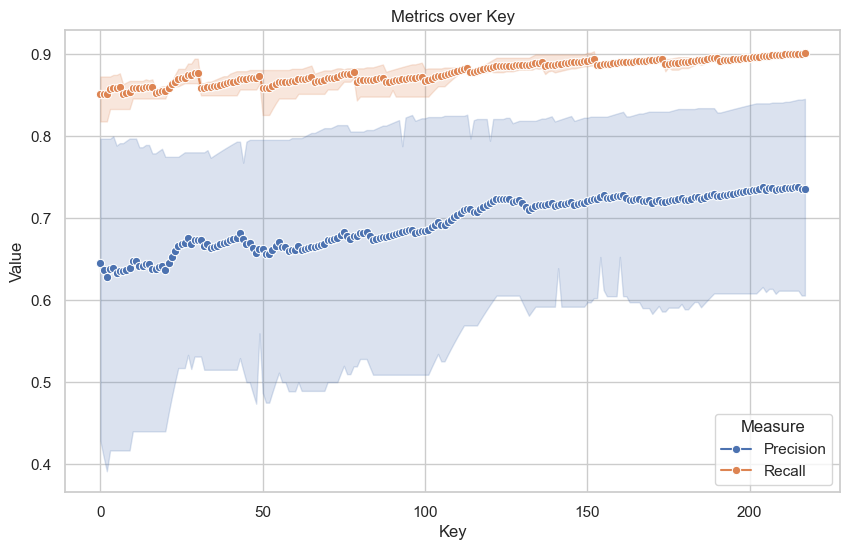

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert data to DataFrame
gradual_metrics_df = pd.DataFrame.from_dict({(i, j): gradual_metrics[i][j] 
                             for i in gradual_metrics.keys() 
                             for j in gradual_metrics[i].keys()},
                            orient='index').reset_index()
gradual_metrics_df.columns = ['Key', 'Metric', 'Precision', 'Recall']

# Melt the dataframe to long-form for seaborn
gradual_metrics_df_melted = gradual_metrics_df.melt(id_vars=['Key', 'Metric'], value_vars=['Precision', 'Recall'], 
                    var_name='Measure', value_name='Value')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=gradual_metrics_df_melted, x='Key', y='Value', hue='Measure', marker='o')

# Add titles and labels
plt.title('Metrics over Key')
plt.xlabel('Key')
plt.ylabel('Value')
plt.legend(title='Measure')
plt.grid(True)

# Show the plot
plt.show()


Feature Importances:
Answer.duration: 0.424
TTR: 0.236
Answer.confidence: 0.126
Answer.difficulty: 0.116
Worker.score: 0.062
Worker.profession: 0.036
Worker.isStudent: 0.000


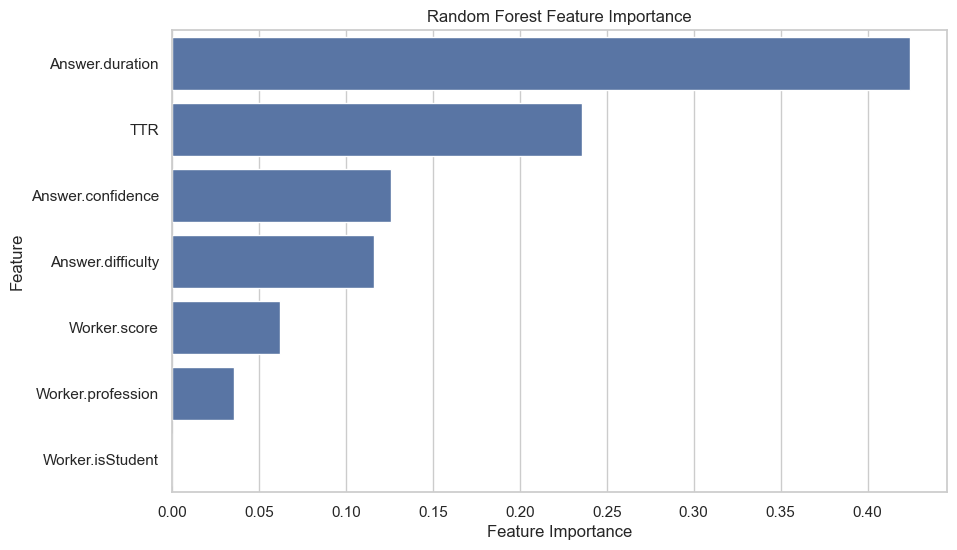

In [96]:
# identify the most important features
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.3f}")

# make plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x=[x[1] for x in sorted_feature_importances], y=[x[0] for x in sorted_feature_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [97]:
# For the inspection tasks (rows) that host the bug, show the distribution of correct labels by
# explanation size and complexity

# meaning: take all rows with ground truth == 1 and ground truth == 0 respectively
# show the distribution of correct labels by explanation size and complexity(TTR)
# correct labels are when the Ground truth == the prediction

import matplotlib.pyplot as plt
import seaborn as sns


# Add a column indicating whether the prediction is correct
holdout_set = holdout_set.copy()  # Avoid SettingWithCopyWarning
holdout_set.loc[:, 'Correct'] = holdout_set['GroundTruth'] == holdout_predictions

# Ensure 'Explanation.size' exists
holdout_set['Explanation.size'] = holdout_set['Answer.explanation'].apply(lambda x: len(str(x)))

# Filter data for Ground_Truth == 1 and GroundTruth == 0
ground_truth_1 = holdout_set[holdout_set['GroundTruth'] == 1].copy()
ground_truth_0 = holdout_set[holdout_set['GroundTruth'] == 0].copy()

# Plot distribution function
def plot_distribution(data, feature, title, ax):
    sns.histplot(data=data, x=feature, hue='Correct', multiple='stack', kde=False, palette='muted', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Set up the plotting grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

# Plot for Explanation.size and TTR for Ground_Truth == 1
plot_distribution(ground_truth_1, 'Explanation.size', 'Correct Labels by Explanation Size (GT=1)', axes[0, 0])
plot_distribution(ground_truth_1, 'TTR', 'Correct Labels by TTR (GT=1)', axes[0, 1])

# Plot for Explanation.size and TTR for Ground_Truth == 0
plot_distribution(ground_truth_0, 'Explanation.size', 'Correct Labels by Explanation Size (GT=0)', axes[1, 0])
plot_distribution(ground_truth_0, 'TTR', 'Correct Labels by TTR (GT=0)', axes[1, 1])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


ValueError: ('Lengths must match to compare', (320,), (103,))

/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/2821570760.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=feature, kde=False, palette='muted', ax=ax)
/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/2821570760.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=feature, kde=False, palette='muted', ax=ax)
/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/2821570760.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=feature, kde=False, palette='muted', ax=ax)
/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/2821570760.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=feature, kde=False, palette='muted', ax=ax)


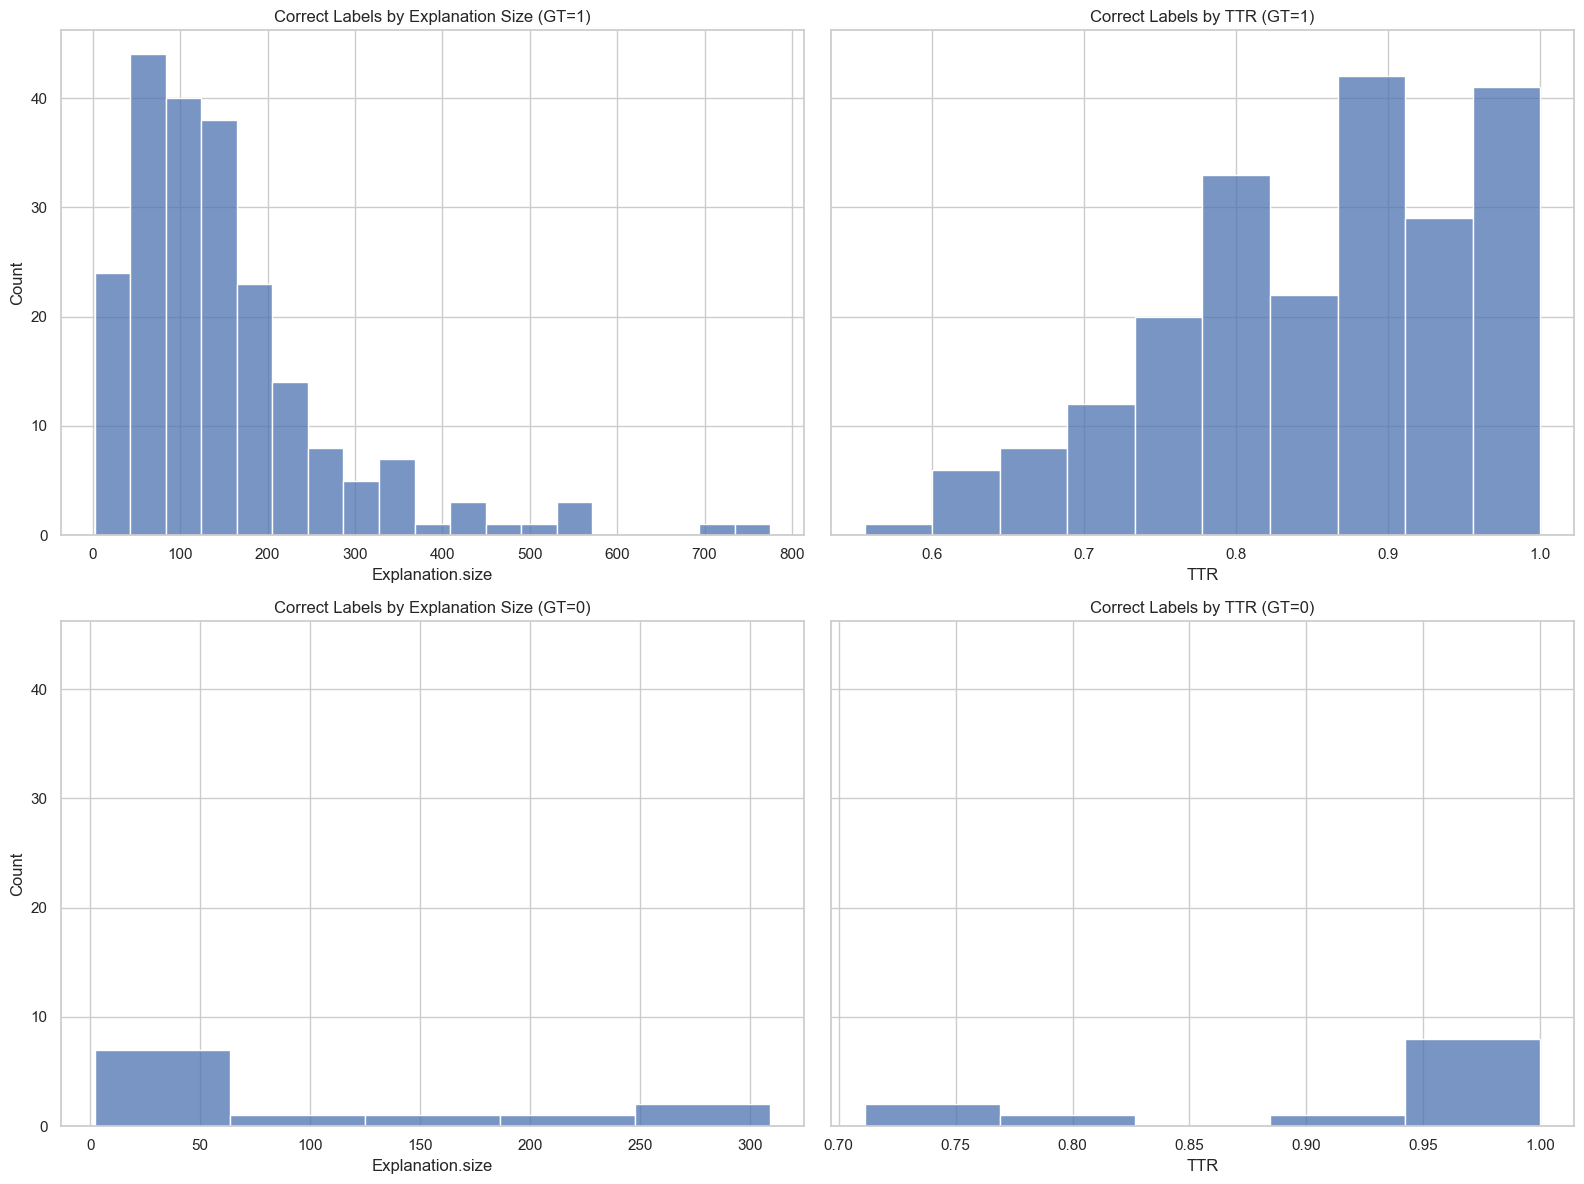

In [ ]:
# Filter only correct predictions
ground_truth_1_correct = ground_truth_1[ground_truth_1['Correct'] == True]
ground_truth_0_correct = ground_truth_0[ground_truth_0['Correct'] == True]

# Create a function to plot distributions for correct labels only
def plot_correct_distribution(data, feature, title, ax):
    sns.histplot(data=data, x=feature, kde=False, palette='muted', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Set up the plotting grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

# Plot for Explanation.size and TTR for Ground_Truth == 1
plot_correct_distribution(ground_truth_1_correct, 'Explanation.size', 'Correct Labels by Explanation Size (GT=1)', axes[0, 0])
plot_correct_distribution(ground_truth_1_correct, 'TTR', 'Correct Labels by TTR (GT=1)', axes[0, 1])

# Plot for Explanation.size and TTR for Ground_Truth == 0
plot_correct_distribution(ground_truth_0_correct, 'Explanation.size', 'Correct Labels by Explanation Size (GT=0)', axes[1, 0])
plot_correct_distribution(ground_truth_0_correct, 'TTR', 'Correct Labels by TTR (GT=0)', axes[1, 1])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/3806616922.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=ground_truth_1, x='Explanation.size', kde=False, palette='muted', ax=axes[0, 0])
/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/3806616922.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=ground_truth_1, x='TTR', kde=False, palette='muted', ax=axes[0, 1])
/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/3806616922.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=ground_truth_0, x='Explanation.size', kde=False, palette='muted', ax=axes[1, 0])
/var/folders/lm/yh5zlf8j2tld7f8zp_7813r40000gn/T/ipykernel_61322/3806616922.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=ground_truth_0, x='TTR', kde=False, palette='muted'

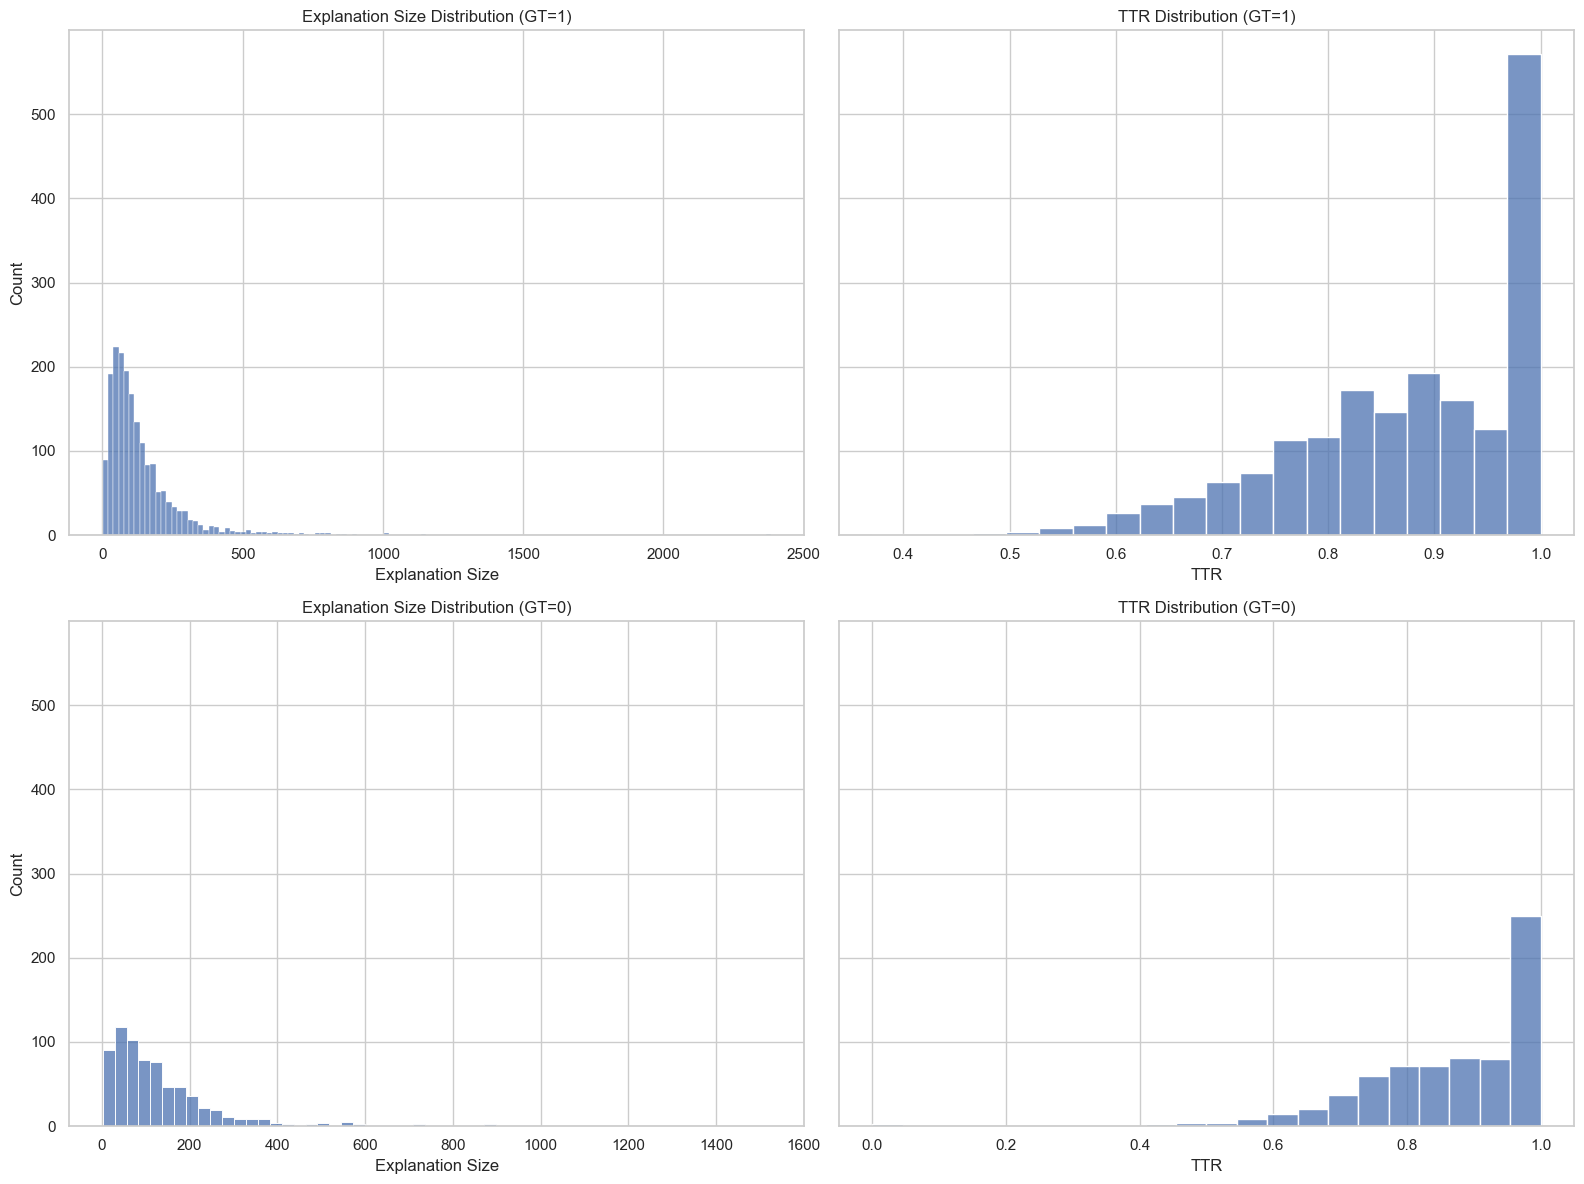

In [15]:
# show explanation size and TTR for GT=1 and GT=0 respectively, disregarding the correctness of the prediction
# Set up the plotting grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

data['Explanation.size'] = data['Answer.explanation'].apply(lambda x: len(str(x)))
ground_truth_1 = data[data['GroundTruth'] == 1].copy()
ground_truth_0 = data[data['GroundTruth'] == 0].copy()

sns.histplot(data=ground_truth_1, x='Explanation.size', kde=False, palette='muted', ax=axes[0, 0])
axes[0, 0].set_title('Explanation Size Distribution (GT=1)')
axes[0, 0].set_xlabel('Explanation Size')
axes[0, 0].set_ylabel('Count')

sns.histplot(data=ground_truth_1, x='TTR', kde=False, palette='muted', ax=axes[0, 1])
axes[0, 1].set_title('TTR Distribution (GT=1)')
axes[0, 1].set_xlabel('TTR')
axes[0, 1].set_ylabel('Count')

sns.histplot(data=ground_truth_0, x='Explanation.size', kde=False, palette='muted', ax=axes[1, 0])
axes[1, 0].set_title('Explanation Size Distribution (GT=0)')
axes[1, 0].set_xlabel('Explanation Size')
axes[1, 0].set_ylabel('Count')

sns.histplot(data=ground_truth_0, x='TTR', kde=False, palette='muted', ax=axes[1, 1])
axes[1, 1].set_title('TTR Distribution (GT=0)')
axes[1, 1].set_xlabel('TTR')
axes[1, 1].set_ylabel('Count')

# Adjust layout and show the plots
data.drop(columns=['Explanation.size'], inplace=True)
plt.tight_layout()
plt.show()

In [16]:
# how often do we predict ground truth 1 and 0 respectively?
print("Predicted Ground Truth 1:", (holdout_predictions == 1).sum())
print("Predicted Ground Truth 0:", (holdout_predictions == 0).sum())

Predicted Ground Truth 1: 288
Predicted Ground Truth 0: 32


In [ ]:
# Or are correct answers just be those with ground truth == 1?

correct_answers = data[data['GroundTruth'] == 1]

# only keep columns GroundTruth,FailingMethod,Answer.explanation
correct_answers = correct_answers[["GroundTruth", "FailingMethod", "Answer.explanation"]]

# Save the correct answers to a CSV file
correct_answers.to_csv("ground_truth_1.csv", index=False)

In [ ]:
# create one file per failing method
# the file should only contain all correct explanations for the respective failing method

for failing_method in data['FailingMethod'].unique():
    failing_method_data = data[data['FailingMethod'] == failing_method]
    failing_method_data = failing_method_data[failing_method_data['GroundTruth'] == 1]
    failing_method_data = failing_method_data[["Answer.explanation"]]
    
    #failing_method_data.to_csv(failing_method + ".csv", index=False)
    # export as txt
    with open(failing_method + ".txt", "w") as file:
        for explanation in failing_method_data["Answer.explanation"]:
            file.write(str(explanation) + "\n")

### Comparing Explanations

In [20]:
# compute BLEU score for the explanations
# Bleu score ranges between 0 and 1, with values closer to 1 indicating more similar texts from the translation.
# https://thepythoncode.com/article/bleu-score-in-python

from nltk.translate.bleu_score import sentence_bleu

failing_methods = data['FailingMethod'].unique()
#failing_methods = ["HIT01_8"]  # testing

for failing_method in failing_methods:
    # Extract reference explanations from the data
    reference_explanations = data[
        (data['FailingMethod'] == failing_method) & 
        (data['GroundTruth'] == 1)
    ]['Answer.explanation']
    
    with open(failing_method + "_summary" + ".txt", "r") as file:
        llm_explanation = file.readlines()
    
    # Split each reference explanation into a list of words
    reference_explanations = [str(explanation).split() for explanation in reference_explanations]
    # Split the hypothesis (LLM explanation) into a list of words
    llm_explanation = llm_explanation[0].split()  # Remove the outer list wrapping

    # Compute BLEU score
    bleu_score = sentence_bleu(reference_explanations, llm_explanation)
    print(f"{failing_method} BLEU Score: {bleu_score:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'HIT01_8_summary.txt'

In [76]:
from math import log, exp
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu

def get_ngrams(text, order):
    """
    Given a string `text` and an integer `order`, returns a Counter object containing
    the frequency counts of all ngrams of size `order` in the string.
    """
    ngrams = Counter()
    words = text.split()
    for i in range(len(words) - order + 1):
        ngram = " ".join(words[i:i + order])
        ngrams[ngram] += 1
    return ngrams

def calculate_bleu(hypothesis, references):
    """
    Calculate BLEU score between hypothesis and multiple references.
    
    Args:
        hypothesis (str): The machine translation to evaluate
        references (list): List of reference translations
        
    Returns:
        tuple: (bleu_score, p1, p2, p3, p4, brevity_penalty)
    """
    # 1. Find the reference with length closest to hypothesis
    hyp_len = len(hypothesis.split())
    ref_lens = [len(ref.split()) for ref in references]
    closest_ref_len = min(ref_lens, key=lambda x: abs(x - hyp_len))
    
    # 2. Calculate modified precision scores for n-grams (p1, p2, p3, p4)
    pns = []
    for order in range(1, 5):
        # Get hypothesis n-grams
        hyp_ngrams = get_ngrams(hypothesis, order)
        
        # Get maximum reference n-gram counts
        max_ref_counts = Counter()
        for ref in references:
            ref_ngrams = get_ngrams(ref, order)
            for ngram, count in ref_ngrams.items():
                max_ref_counts[ngram] = max(max_ref_counts[ngram], count)
        
        # Calculate clipped counts
        clipped_counts = Counter()
        for ngram, count in hyp_ngrams.items():
            clipped_counts[ngram] = min(count, max_ref_counts[ngram])
        
        # Calculate modified precision
        denominator = max(sum(hyp_ngrams.values()), 1)
        numerator = sum(clipped_counts.values())
        p_n = numerator / denominator
        pns.append(p_n)
    
    # 3. Calculate brevity penalty
    bp = 1.0
    if hyp_len < closest_ref_len:
        bp = exp(1 - closest_ref_len / hyp_len)
    
    # 4. Calculate final BLEU score
    weights = [0.25] * 4
    if all(p_n > 0 for p_n in pns):
        bleu = bp * exp(sum(w * log(p_n) for w, p_n in zip(weights, pns)))
    else:
        bleu = 0.0
    
    p1, p2, p3, p4 = pns
    return bleu, p1, p2, p3, p4, bp


for failing_method in failing_methods:
    # Extract reference explanations
    reference_explanations = data[
        (data['FailingMethod'] == failing_method) &
        (data['GroundTruth'] == 1)
    ]['Answer.explanation']
    
    # Read LLM explanation
    with open(failing_method + "_summary.txt", "r") as file:
        llm_explanation = file.readline().strip()
    
    # Calculate BLEU score
    bleu_score, p1, p2, p3, p4, bp = calculate_bleu(
        llm_explanation,
        [str(exp) for exp in reference_explanations]
    )
    
    print(f"{failing_method} BLEU Score: {bleu_score:.2f}, "
            f"P1: {p1:.2f}, P2: {p2:.2f}, P3: {p3:.2f}, P4: {p4:.2f}, BP: {bp:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'HIT01_8_summary.txt'

In [72]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL', 'rouge1', 'rouge2'], use_stemmer=True)

failing_methods = data['FailingMethod'].unique()

for failing_method in failing_methods:
    # Extract reference explanations from the data
    reference_explanations = data[
        (data['FailingMethod'] == failing_method) & 
        (data['GroundTruth'] == 1)
    ]['Answer.explanation']
    
    with open(failing_method + "_summary" + ".txt", "r") as file:
        llm_explanation = file.read().strip()  # Read entire content as a string and strip extra whitespace
    
    # Compute ROUGE scores individually for each reference
    scores = {key: [] for key in ['rougeL', 'rouge1', 'rouge2']}
    for ref in reference_explanations:
        ref_str = str(ref).strip()  # Ensure ref is a string and strip extra whitespace
        temp_scores = scorer.score(ref_str, llm_explanation)

        for key in temp_scores:
            scores[key].append(temp_scores[key].fmeasure)  # Use the F-measure as the score

    # Print the scores for each failing method
    print(f'{failing_method}')
    for key in scores:
        print(f'{key} - avg score: {sum(scores[key]) / len(scores[key]):.2f}, all scores: {scores[key]}')

    print("\n")


HIT01_8
rougeL - avg score: 0.13, all scores: [0.09638554216867469, 0.27350427350427353, 0.10638297872340424, 0.16326530612244897, 0.1728395061728395, 0.1782178217821782, 0.14516129032258063, 0.19999999999999998, 0.23728813559322032, 0.2204724409448819, 0.048192771084337345, 0.12048192771084336, 0.051948051948051945, 0.05405405405405406, 0.15053763440860213, 0.14814814814814814, 0.2391304347826087, 0.027397260273972605, 0.12280701754385967, 0.07894736842105263, 0.13636363636363635, 0.12195121951219512, 0.21238938053097345, 0.025641025641025644, 0.23655913978494625, 0.125, 0.13592233009708737, 0.1818181818181818, 0.15789473684210525, 0.02777777777777778, 0.027397260273972605, 0.18947368421052632, 0.18604651162790695, 0.08888888888888888, 0.08, 0.14457831325301204, 0.027397260273972605, 0.10526315789473685, 0.10256410256410257, 0.15384615384615383]
rouge1 - avg score: 0.22, all scores: [0.16867469879518074, 0.39316239316239315, 0.2553191489361702, 0.2040816326530612, 0.3209876543209877, 